torch.Size([1, 1, 28, 28])
Adversarial attack successful at step 18!


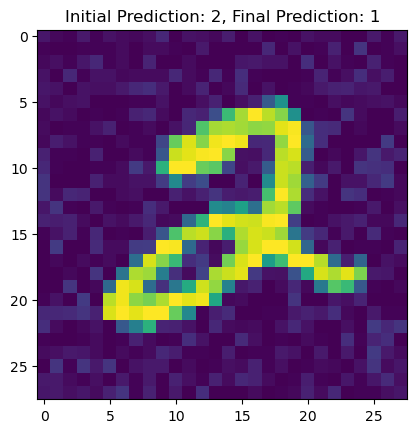

In [25]:
import sys
import os
import torch
import torch.nn as nn
CONTENT_PATH = '/home/yifan/0ExpMinist/Default/02'
sys.path.append(CONTENT_PATH)
import Model.model as subject_model
model = eval("subject_model.{}()".format('resnet18'))
import matplotlib.pyplot as plt
# 加载预训练模型

model_location = os.path.join(CONTENT_PATH,'Model', "{}_{:d}".format('Epoch', 3), "subject_model.pth")
model.load_state_dict(torch.load(model_location, map_location=torch.device("cpu")),strict=False)
model.eval()

train_data = torch.load(os.path.join(CONTENT_PATH, 'Training_data','training_dataset_data.pth'))
train_labels = torch.load(os.path.join(CONTENT_PATH, 'Training_data','training_dataset_label.pth'))
img_tensor = train_data[5:6]
img_label = train_labels[5:6]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img_tensor = img_tensor.to(device)
img_label = img_label.to(device)
model = model.to(device)
print(img_tensor.shape)
# Set the target label to '1'
target_label = torch.tensor([1], dtype=torch.long).to(device)


loss_fn = torch.nn.CrossEntropyLoss()
# # 设置epsilon

epsilon = 0.01  # Smaller step size for iterative attack
num_steps = 1000 
# Set requires_grad attribute of tensor. Important for Attack
img_tensor.requires_grad = True
# Forward pass the data through the model
output = model(img_tensor)
init_pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
# If the initial prediction is already '1', no need to attack
steps = []
if init_pred.item() == 1:
    print("The initial prediction is already 1")
else:
    for i in range(num_steps):
        # Zero all existing gradients
        model.zero_grad()
        # Forward pass
        output = model(img_tensor)
        loss = loss_fn(output, target_label)
        # If misclassification has occurred, break out of the loop
        pred = output.max(1, keepdim=True)[1]
        steps.append(img_tensor)
        if pred.item() == 1:
            print(f"Adversarial attack successful at step {i+1}!")
            break
        # Backward pass
        loss.backward()

        # Apply perturbation
        img_tensor.data -= epsilon * img_tensor.grad.data.sign()  # Subtract to minimize the loss
        img_tensor.data = torch.clamp(img_tensor.data, 0, 1).to(device)
        # Clear gradients for next step
        img_tensor.grad.zero_()

    else:
        print("Failed to fool the model within the given steps.")
 
    # Display final result
    final_pred = model(img_tensor).max(1, keepdim=True)[1]
    perturbed_image_np = img_tensor.squeeze().detach().cpu().numpy()
    plt.imshow(perturbed_image_np)
    plt.title(f"Initial Prediction: {init_pred.item()}, Final Prediction: {final_pred.item()}")
    plt.show()

In [22]:
len(steps)

8